### What is this script for?
This is a R tutorial code for interrupted time series(ITS) analysis.  
This script is the representation of the article below.  
https://academic.oup.com/ije/article/46/1/348/2622842

In [0]:
library(foreign)
library(splines)
install.packages("tsModel"); library(tsModel)
install.packages("lmtest"); library(lmtest)
install.packages("Epi"); library(Epi)
install.packages("vcd"); library(vcd)

First, let's import the dataset from the supplementary data of the article.  
https://academic.oup.com/ije/article/46/1/348/2622842

In [8]:
data <- read.csv("sicily.csv")
head(data)

,year,month,aces,time,smokban,pop,stdpop
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,2002,1,728,1,0,364277.4,379875.3
2,2002,2,659,2,0,364277.4,376495.5
3,2002,3,791,3,0,364277.4,377040.8
4,2002,4,734,4,0,364277.4,377116.4
5,2002,5,757,5,0,364277.4,377383.4
6,2002,6,726,6,0,364277.4,374113.1


This dataset includes the following variables:

* year
* month
* time = elapsed time since the start of the study
* aces = count of acute coronary episodes in Sicily per month (the outcome)
* smokban = smoking ban (the intervention) coded 0 before intervention, 1 after
* pop = the population of Sicily (in 10000s)
* stdpop =  age standardised population
  
   
And we add the standardized rates of ACE emissions.

In [0]:
data$rate <- with(data, aces/stdpop * 10 ^ 5)

Next, we visualize the trend of monthly rates of ACE admissions.  

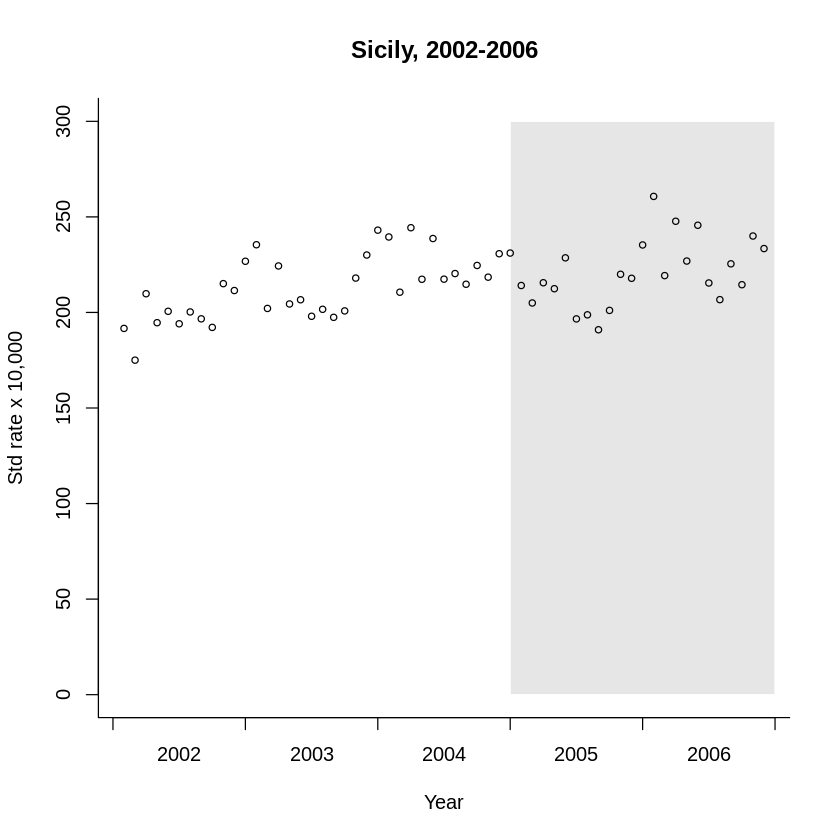

In [37]:
plot(data$rate, type="n", ylim=c(0, 300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 0, 60, 300, col=grey(0.9), border=FALSE)
points(data$rate, cex=0.7)
axis(1, at=0:5 * 12, labels=FALSE)
axis(1, at=0:4 * 12 + 6, tick=FALSE, labels=2002:2006)
title("Sicily, 2002-2006")

### Poisson Regression Model
Firstly, we chose a step change model and also used a Poisson model as we are using count data.

The formula of ITS analysis is like below. 
$$Y_t=β_0 +β_1T+β_2X_t + β_3TX_t$$

where  
* $β_0$ represents the baseline level at $T = 0$
* $β_1$ is interpreted as the change in outcome associated with a time unit increase (representing the underlying pre-intervention trend),  
* $β_2$ is the level change following the intervention  
* $β_3$ indicates the slope change following the intervention (using the interaction between time and intervention: $TX_t$ ⁠).

In [30]:
model1 <- glm(aces ~ offset(log(stdpop)) + smokban + time, family=poisson(), data=data)
round(ci.lin(model1, Exp=T), 3)

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.243,0.011,-557.955,0,0.002,0.002,0.002
smokban,-0.112,0.017,-6.481,0,0.894,0.865,0.925
time,0.005,0.000,9.905,0,1.005,1.004,1.006


In [27]:
summary(model1)$dispersion

[1] 1

In [0]:
datanew <- data.frame(stdpop=mean(data$stdpop), smokban=rep(c(0,1), c(360,240)), time=1:600/10, month=rep(1:120/10, 5))
pred1 <- predict(model1, type="response", datanew) / mean(data$stdpop)*10 ^ 5
datanew <- data.frame(stdpop=mean(data$stdpop), smokban=0, time=1:600/10, month=rep(1:120/10, 5), time=1:600/10, month=rep(1:120/10, 5))

The chart below is the fitted regression trend(red line) and the counterfactual scenario(dashed line).  

As you can see, the trend of the outcome(red line) is suddenly declined at the time of the intervention, so this can be considered as the intervention effect to the level of the outcome.

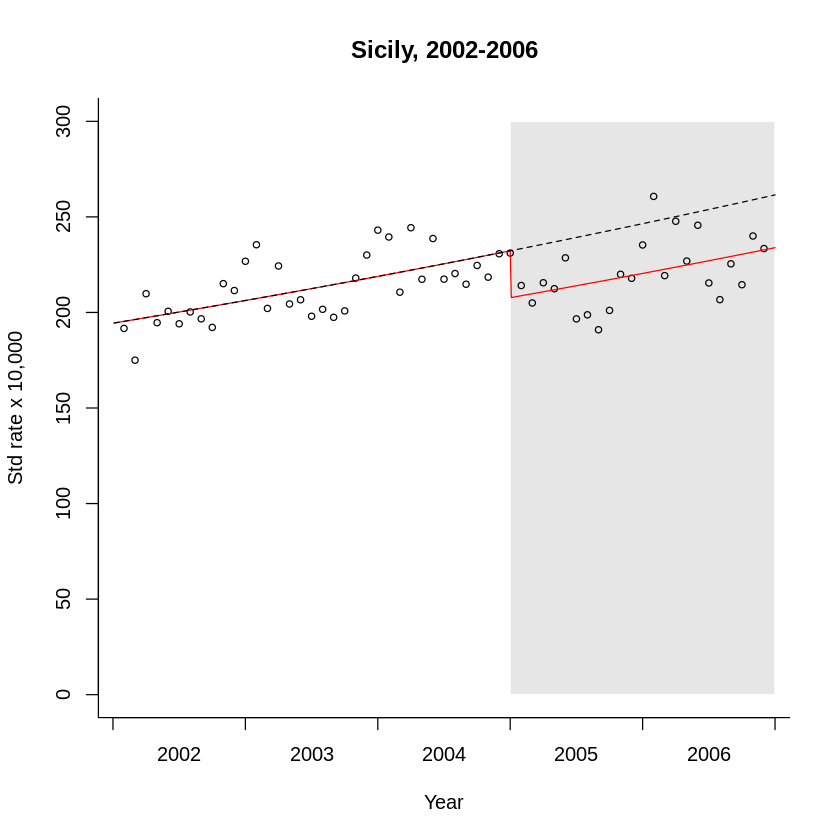

In [36]:
plot(data$rate, type="n", ylim=c(0,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 0, 60, 300, col=grey(0.9), border=F)
points(data$rate, cex=0.7)
axis(1, at=0:5*12, labels=F)
axis(1, at=0:4*12+6, tick=F, labels=2002:2006)
lines((1:600/10), pred1, col=2)
title("Sicily, 2002-2006")
pred1b <- predict(model1, datanew, type="response") / mean(data$stdpop) * 10 ^ 5
lines(datanew$time, pred1b, col=1, lty=2)

### Quasi-Poisson model 
In the model above we have not allowed for overdispersion.  
In order to do this we can use a quasipoisson model, which allows the variance to be  proportional rather than equal to the mean.


In [40]:
model2 <- glm(aces ~ offset(log(stdpop)) + smokban + time, family=quasipoisson(), data)
round(ci.lin(model2, Exp=T), 3)

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.243,0.021,-295.749,0.000,0.002,0.002,0.002
smokban,-0.112,0.032,-3.435,0.001,0.894,0.839,0.953
time,0.005,0.001,5.250,0.000,1.005,1.003,1.007


In [39]:
summary(model2)$dispersion

[1] 3.559195

### Model checking and autocorrelation
Check the residuals by plotting against time.

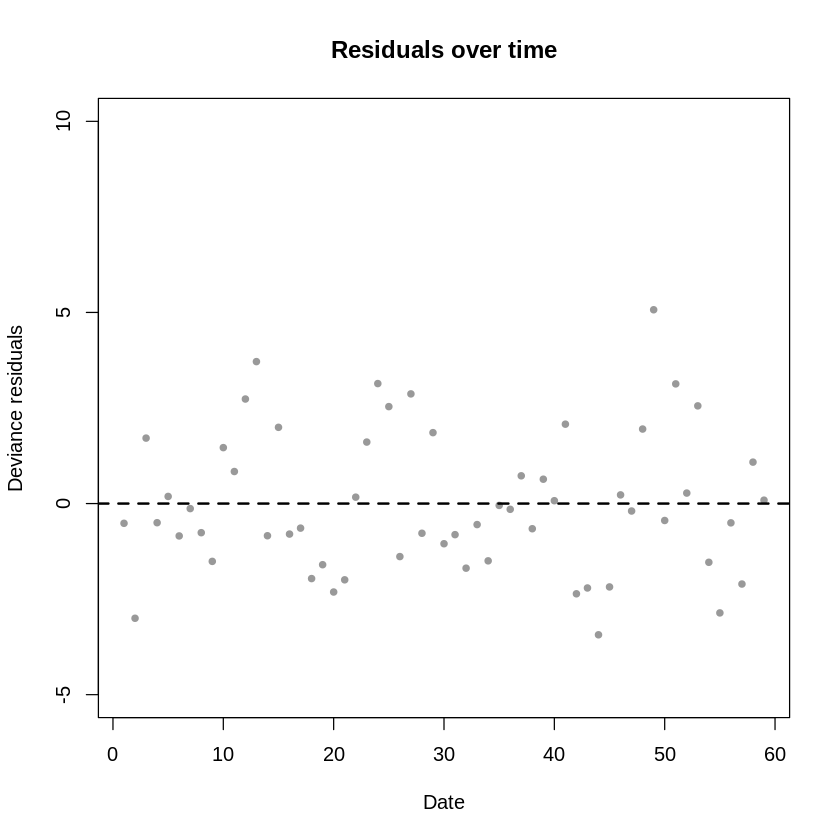

In [41]:
res2 <- residuals(model2, type="deviance")
plot(data$time, res2, ylim=c(-5, 10), pch=19, cex=0.7, col=grey(0.6), main="Residuals over time", ylab="Deviance residuals", xlab="Date")
abline(h=0, lty=2, lwd=2)

Further check for autocorrelation by examining the autocorrelation and partial autocorrelation functions.

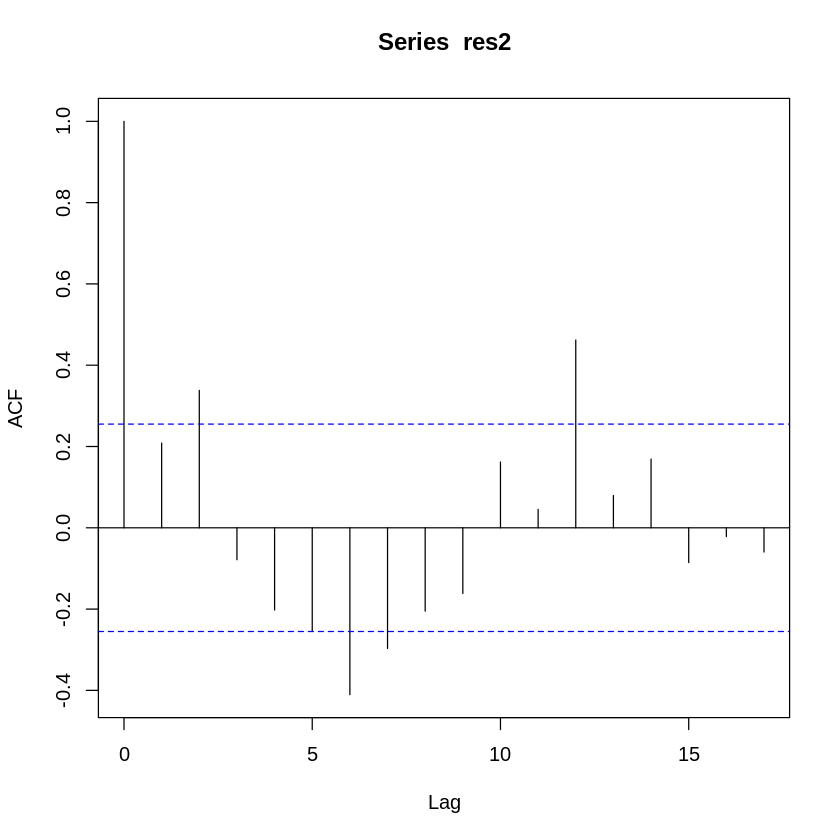

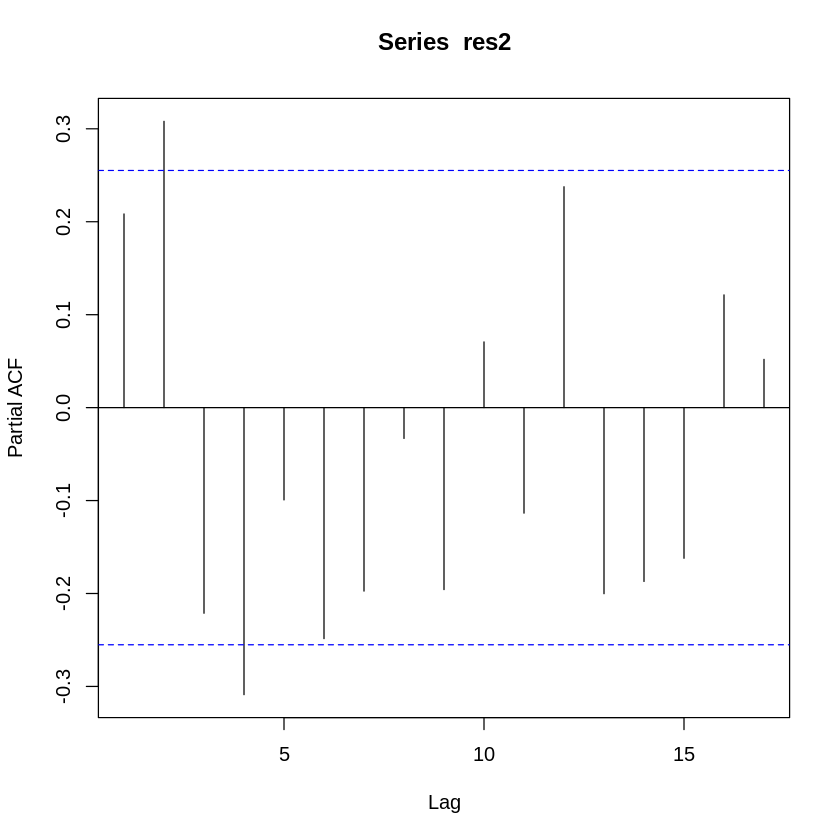

In [42]:
acf(res2)
pacf(res2)

### Adjusting for seasonality
There are various ways of adjusting for seasonality.  
Here we use harmonic terms specifying the number of sin and cosine pairs to include and the length of the period (12 months).


In [43]:
model3 <- glm(aces ~ offset(log(stdpop)) + smokban + time + harmonic(month, 2, 12), family=quasipoisson(), data)
round(ci.lin(model3, Exp=T), 3)

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.252,0.018,-355.877,0.000,0.002,0.002,0.002
smokban,-0.122,0.027,-4.517,0.000,0.885,0.839,0.933
time,0.005,0.001,6.774,0.000,1.005,1.004,1.007
"harmonic(month, 2, 12)1",0.037,0.010,3.701,0.000,1.038,1.018,1.058
"harmonic(month, 2, 12)2",-0.018,0.010,-1.889,0.059,0.982,0.964,1.001
"harmonic(month, 2, 12)3",0.038,0.010,3.940,0.000,1.039,1.019,1.059
"harmonic(month, 2, 12)4",0.015,0.010,1.519,0.129,1.015,0.996,1.034


In [44]:
summary(model3)$dispersion

[1] 2.262186

In [48]:
# EFFECTS
round(ci.lin(model3, Exp=T)["smokban", 5:7], 3)

exp(Est.)      2.5%     97.5% 
    0.885     0.839     0.933

In [49]:
# TREND
exp(coef(model3)["time"] * 12)

time 
1.066808

We again check the model and autocorrelation functions.

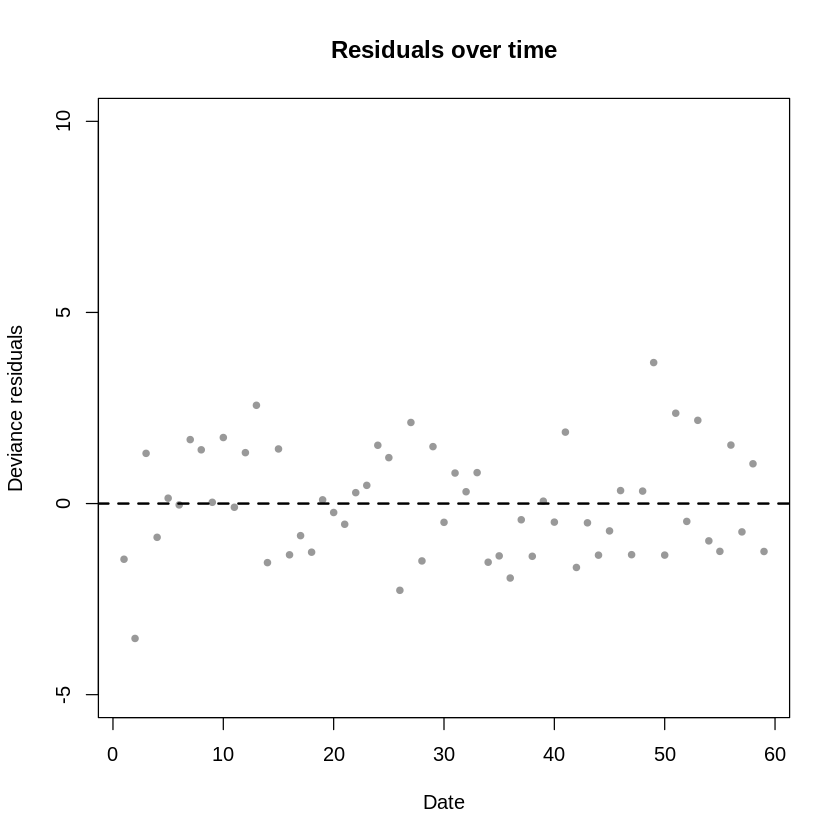

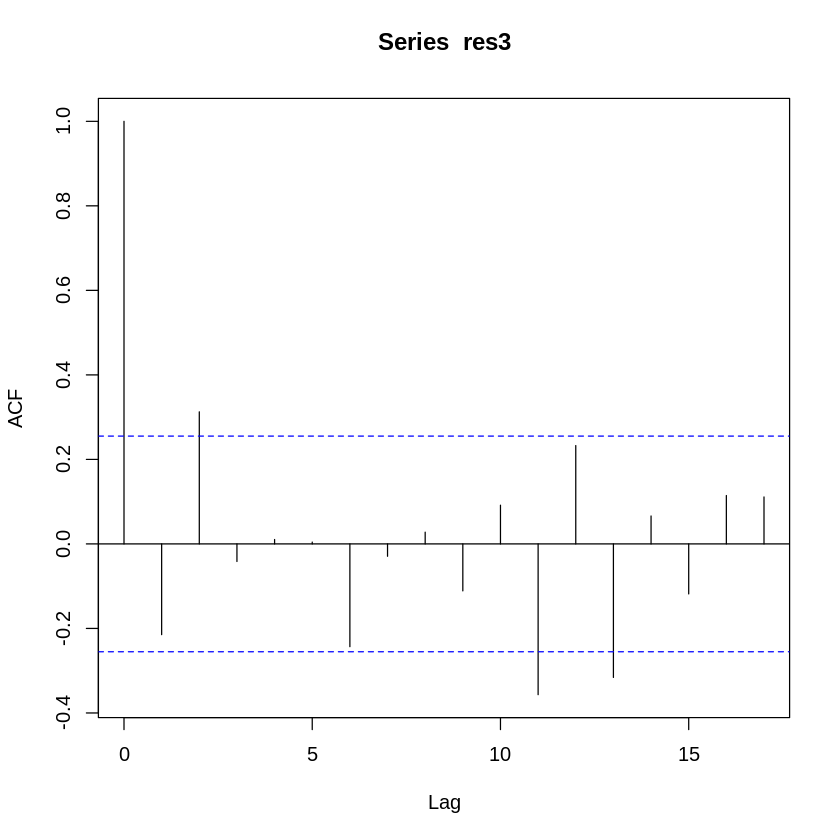

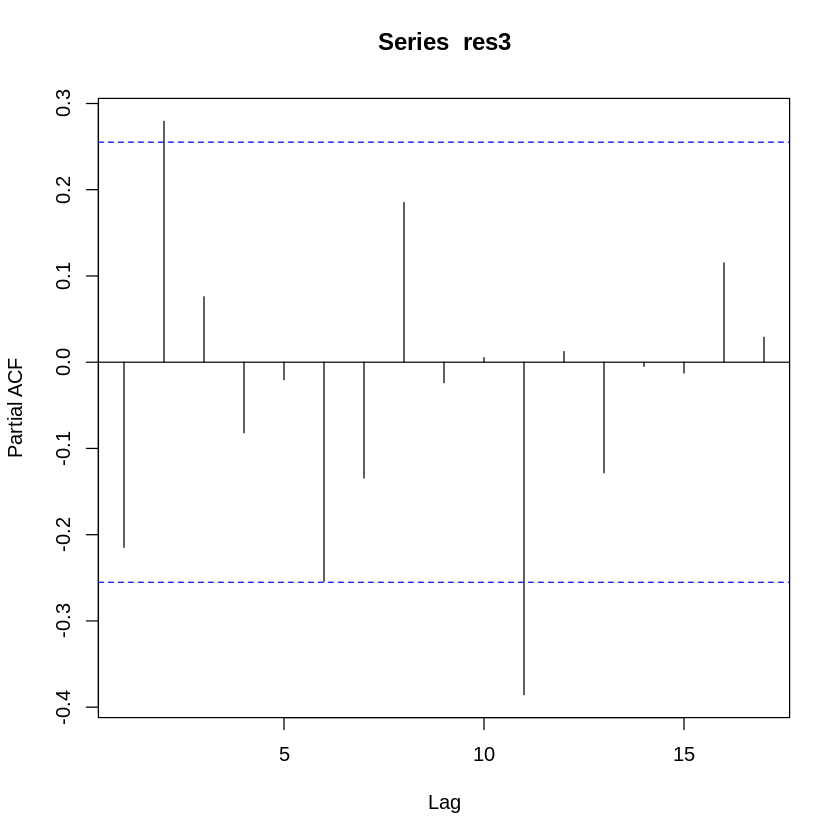

In [50]:
res3 <- residuals(model3, type="deviance")
plot(res3, ylim=c(-5,10), pch=19, cex=0.7, col=grey(0.6), main="Residuals over time", ylab="Deviance residuals", xlab="Date")
abline(h=0, lty=2, lwd=2)
acf(res3)
pacf(res3)

Predict and plot of the seasonally adjusted model.

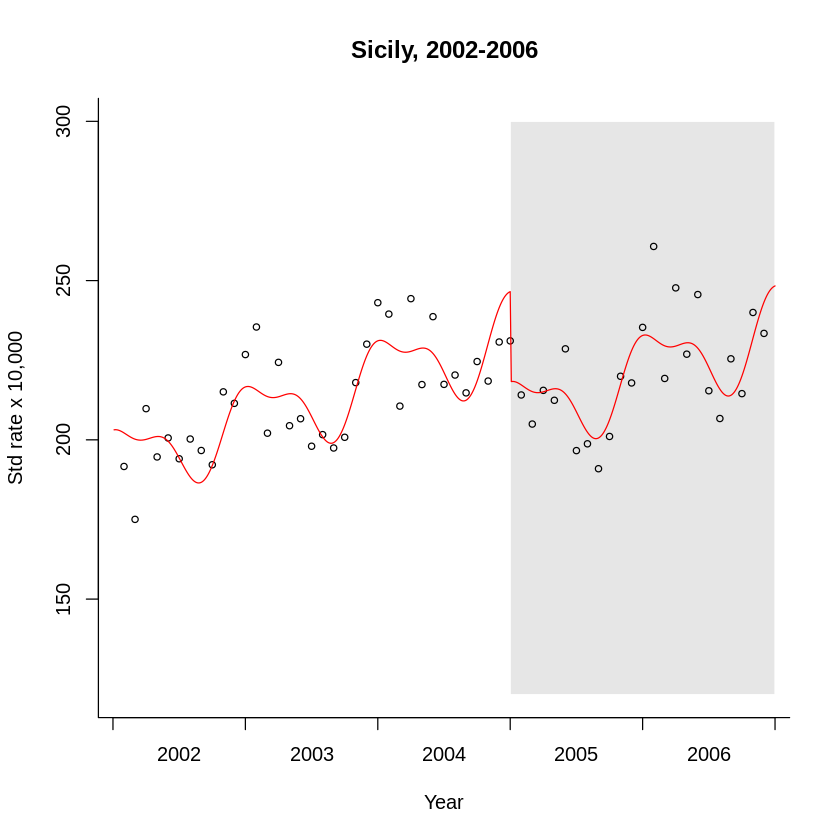

In [53]:
datanew <- data.frame(stdpop=mean(data$stdpop), smokban=rep(c(0, 1), c(360, 240)), time= 1:600 / 10, month=rep(1:120 / 10, 5))

pred3 <- predict(model3, type="response", datanew) / mean(data$stdpop) * 10 ^ 5
plot(data$rate, type="n", ylim=c(120,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 120, 60, 300, col=grey(0.9), border=FALSE)
points(data$rate, cex=0.7)
axis(1, at=0:5 * 12, labels=FALSE)
axis(1, at=0:4 * 12 + 6,tick=FALSE, labels=2002:2006)
lines(1:600 / 10, pred3, col=2)
title("Sicily, 2002-2006")

It is sometimes difficult to clearly see the change graphically in the seasonally adjusted model.  
Therefore it can be useful to plot a straight line representing a 'deseasonalised' trend.  

This can be done by predicting all the observations for the same month, in this case we use June.

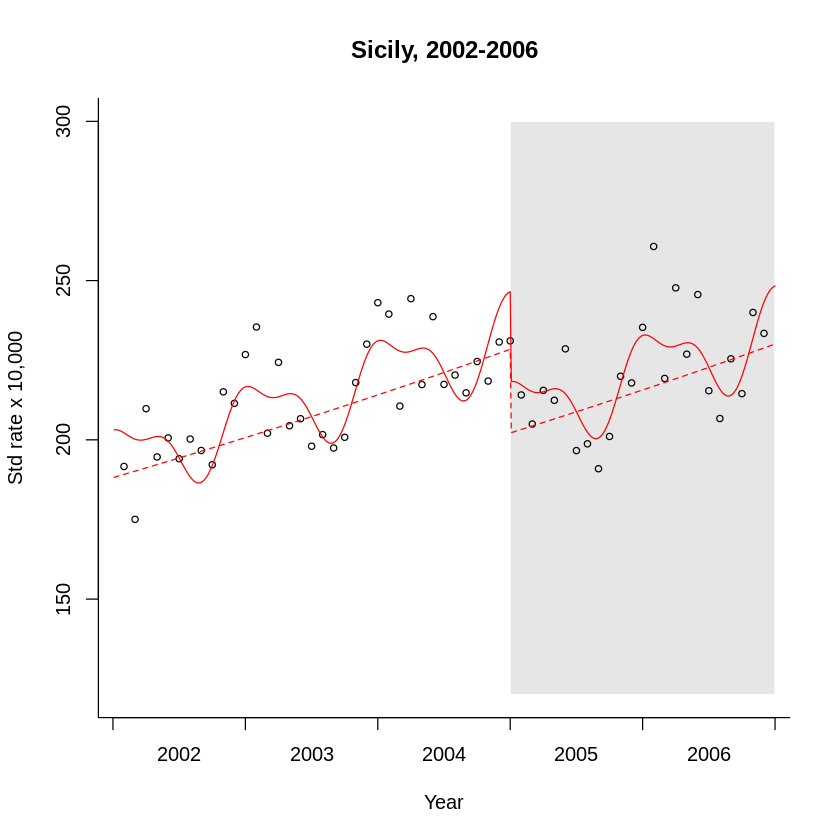

In [62]:
plot(data$rate, type="n", ylim=c(120,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 120, 60, 300, col=grey(0.9), border=FALSE)
points(data$rate, cex=0.7)
axis(1, at=0:5 * 12, labels=FALSE)
axis(1, at=0:4 * 12 + 6,tick=FALSE, labels=2002:2006)
lines(1:600 / 10, pred3, col=2)
title("Sicily, 2002-2006")

#this can then be added to the plot as a dashed line
pred3b <- predict(model3, type="response", transform(datanew, month=6)) / mean(data$stdpop) * 10 ^ 5
lines(1:600 / 10, pred3b, col=2, lty=2)

### Additional Material
Add a change-in-slope.  
We parameterize it as an interaction between time and the ban indicator.


In [57]:
model4 <- glm(aces ~ offset(log(stdpop)) + smokban * time + harmonic(month, 2, 12), family=quasipoisson(), data)
round(ci.lin(model4, Exp=T), 3)

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.247,0.019,-330.930,0.000,0.002,0.002,0.002
smokban,-0.185,0.084,-2.217,0.027,0.831,0.705,0.979
time,0.005,0.001,5.835,0.000,1.005,1.003,1.007
"harmonic(month, 2, 12)1",0.038,0.010,3.769,0.000,1.039,1.019,1.060
"harmonic(month, 2, 12)2",-0.018,0.010,-1.818,0.069,0.983,0.964,1.001
"harmonic(month, 2, 12)3",0.038,0.010,3.948,0.000,1.039,1.020,1.059
"harmonic(month, 2, 12)4",0.015,0.010,1.535,0.125,1.015,0.996,1.035
smokban:time,0.001,0.002,0.799,0.424,1.001,0.998,1.005


Predict and plot the 'deseasonalised' trend.  
Compare it with the step-change only model.

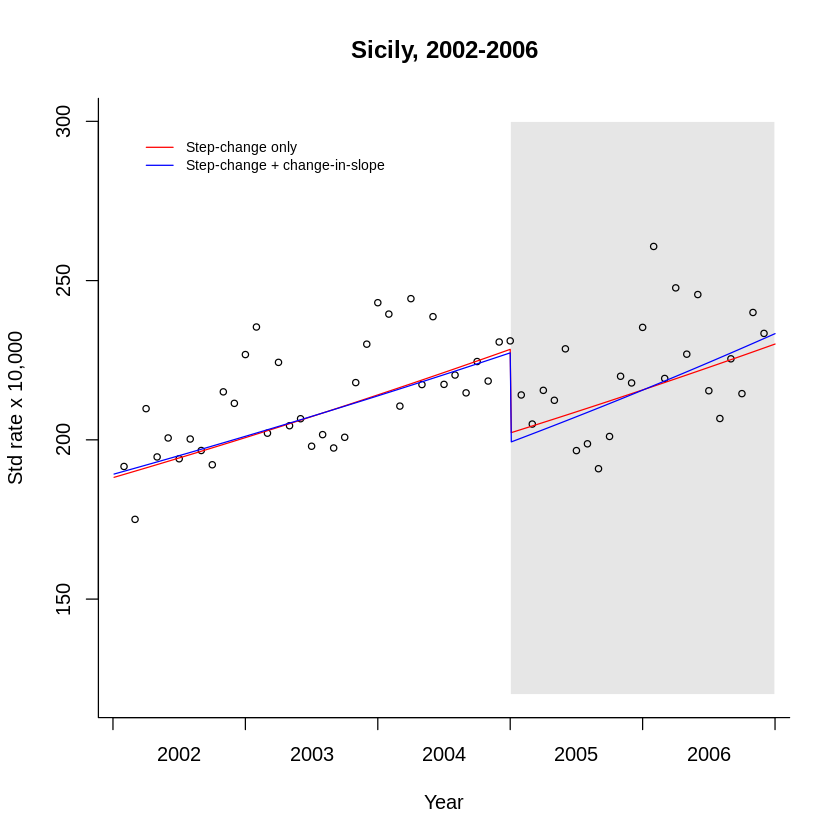

In [60]:
pred4b <- predict(model4, type="response", transform(datanew, month=6)) / mean(data$stdpop) * 10 ^ 5
plot(data$rate, type="n", ylim=c(120,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 120, 60, 300, col=grey(0.9), border=FALSE)
points(data$rate, cex=0.7)
axis(1, at=0:5 * 12, labels=FALSE)
axis(1, at=0:4 * 12 + 6,tick=FALSE, labels=2002:2006)
lines(1:600 / 10, pred3b, col=2)
lines(1:600 / 10, pred4b, col=4)
title("Sicily, 2002-2006")
legend("topleft", c("Step-change only", "Step-change + change-in-slope"), lty=1, col=c(2,4), inset=0.05, bty="n", cex=0.7)

Test if the change-in-slope improve the fit.  
The selected test here is an F-test, which accounts for the overdispersion, while in other cases a likelihood ratio or wald test can be applied.

In [61]:
anova(model3, model4, test="F")

,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,52,117.2661,NA,NA,NA,NA
2,51,115.8131,1,1.452971,0.6387915,0.4278555


Not surprisingly, the p-value is similar to that of the interaction term.